In [1]:
import rasterio
import numpy as np
import os

MULT = 0.00341802
ADD = 149.0

def convert_folder_b10(root_dir):
    count = 0
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("_ST_B10.TIF") and "_Celsius" not in file:
                input_path = os.path.join(root, file)
                output_path = input_path.replace(".TIF", "_Celsius.TIF")
                
                if os.path.exists(output_path):
                    continue
                print(f"processing: {file}...")
                try:
                    with rasterio.open(input_path) as src:
                        
                        dn_values = src.read(1)
                        meta = src.meta.copy()
                        
                        # Celsius = (DN * 0.00341802) + 149.0 - 273.15
                        celsius_values = (dn_values.astype('float32') * MULT) + ADD - 273.15

                        celsius_values[dn_values == 0] = np.nan

                        meta.update({
                            "dtype": 'float32',
                            "nodata": np.nan
                        })

                        with rasterio.open(output_path, 'w', **meta) as dst:
                            dst.write(celsius_values, 1)
                    
                    count += 1
                except Exception as e:
                    print(f"convert {file} fail: {e}")

    print(f"\n finish {count} LST files。")

data_path = "./Data" 

if __name__ == "__main__":
    if os.path.exists(data_path):
        convert_folder_b10(data_path)
    else:
        print(f" no such file {data_path}")

正在处理: LC08_L2SP_044033_20240703_20250616_02_T1_ST_B10.TIF...
正在处理: LC08_L2SP_044033_20240719_20240723_02_T1_ST_B10.TIF...
正在处理: LC09_L2SP_044033_20240828_20240829_02_T1_ST_B10.TIF...
正在处理: LC08_L2SP_044033_20240601_20240611_02_T1_ST_B10.TIF...
正在处理: LC08_L2SP_044033_20240617_20240705_02_T1_ST_B10.TIF...
正在处理: LC08_L2SP_044033_20240804_20240808_02_T1_ST_B10.TIF...
正在处理: LC08_L2SP_044033_20240820_20240830_02_T1_ST_B10.TIF...
正在处理: LC09_L2SP_044033_20240711_20240712_02_T1_ST_B10.TIF...
正在处理: LC09_L2SP_044033_20240812_20240813_02_T1_ST_B10.TIF...

✨ 任务完成！共转换了 9 个地表温度文件。


In [2]:
import rasterio
import numpy as np
import pandas as pd
import os
import glob

TRAIN_DIR = "./Data/train"
OUTPUT_CSV = "LST_Training_Samples.csv"
SAMPLES_PER_IMAGE = 10000

def extract_features(folder):
    try:
        b4_path = glob.glob(os.path.join(folder, "*_SR_B4.TIF"))[0]
        b5_path = glob.glob(os.path.join(folder, "*_SR_B5.TIF"))[0]
        b6_path = glob.glob(os.path.join(folder, "*_SR_B6.TIF"))[0]
        b7_path = glob.glob(os.path.join(folder, "*_SR_B7.TIF"))[0]
        lst_path = glob.glob(os.path.join(folder, "*_ST_B10_Celsius.TIF"))[0]
        emi_path = glob.glob(os.path.join(folder, "*_ST_EMIS.TIF"))[0]
        qa_path  = glob.glob(os.path.join(folder, "*_QA_PIXEL.TIF"))[0]

        with rasterio.open(b4_path) as b4, rasterio.open(b5_path) as b5, \
             rasterio.open(b6_path) as b6, rasterio.open(b7_path) as b7, \
             rasterio.open(lst_path) as lst, rasterio.open(emi_path) as emi, \
             rasterio.open(qa_path) as qa:
            
            red = b4.read(1).flatten().astype('float32')
            nir = b5.read(1).flatten().astype('float32')
            swir1 = b6.read(1).flatten().astype('float32')
            swir2 = b7.read(1).flatten().astype('float32')
            temp = lst.read(1).flatten()
            emiss = emi.read(1).flatten().astype('float32') * 0.0001
            quality = qa.read(1).flatten()

            # NDVI = (nir - red) / (nir + red)
            ndvi = (nir - red) / (nir + red + 1e-6)
            # NDBI = (swir1 - nir) / (swir1 + nir)
            ndbi = (swir1 - nir) / (swir1 + nir + 1e-6)

            mask = (quality == 21824) & (~np.isnan(temp)) & (temp > 0)
            
            df = pd.DataFrame({
                'NDVI': ndvi[mask],
                'NDBI': ndbi[mask],
                'B6': swir1[mask],
                'B7': swir2[mask],
                'Emissivity': emiss[mask],
                'LST_Label': temp[mask]
            })

            if len(df) > SAMPLES_PER_IMAGE:
                return df.sample(n=SAMPLES_PER_IMAGE, random_state=42)
            else:
                return df

    except Exception as e:
        print(f"skip {folder}: {e}")
        return None

if __name__ == "__main__":
    all_data = []
    subfolders = [os.path.join(TRAIN_DIR, d) for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    
    print(f"start processing {len(subfolders)} files...")
    
    for folder in subfolders:
        sample_df = extract_features(folder)
        if sample_df is not None:
            all_data.append(sample_df)
            print(f"extracted sample: {os.path.basename(folder)} ({len(sample_df)} ")

    final_dataset = pd.concat(all_data, ignore_index=True)
    final_dataset.to_csv(OUTPUT_CSV, index=False)
    print(f"\n sample saved: {OUTPUT_CSV}")
    print(f"total samples: {len(final_dataset)}")

开始处理 6 个影像文件夹...
已提取: LC08_L2SP_044033_20240601_20240611_02_T1 (10000 样本)
已提取: LC08_L2SP_044033_20240617_20240705_02_T1 (10000 样本)
已提取: LC08_L2SP_044033_20240804_20240808_02_T1 (10000 样本)
已提取: LC08_L2SP_044033_20240820_20240830_02_T1 (10000 样本)
已提取: LC09_L2SP_044033_20240711_20240712_02_T1 (10000 样本)
已提取: LC09_L2SP_044033_20240812_20240813_02_T1 (10000 样本)

✅ 特征工程完成！样本已保存至: LST_Training_Samples.csv
总样本量: 60000


训练样本数: 48000
测试样本数: 12000

正在训练模型，请稍候...

========== 模型评估结果 ==========
R² (决定系数): 0.559
MAE (平均绝对误差): 4.29 °C
RMSE (均方根误差): 5.46 °C


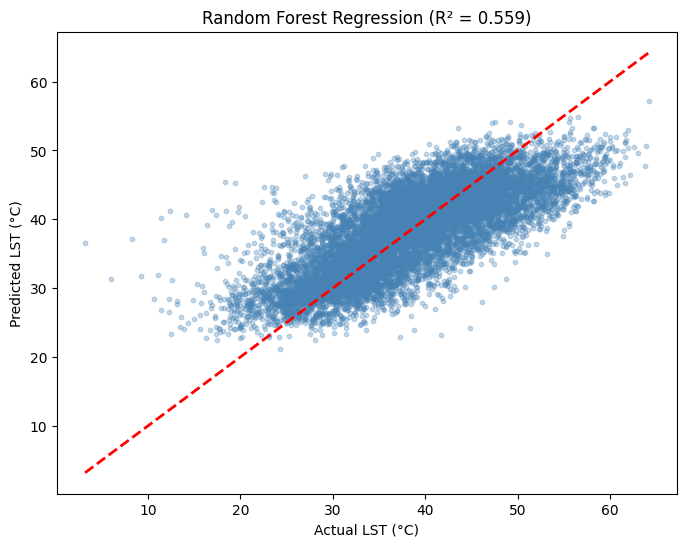


✅ 模型已保存为: lst_rf_model.pkl


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

data = pd.read_csv("LST_Training_Samples.csv")

features = ['NDVI', 'NDBI', 'B6', 'B7', 'Emissivity']
X = data[features]
y = data['LST_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"training sample: {len(X_train)}")
print(f"testing sample: {len(X_test)}")

print("\n training model...")
rf_model = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=42, n_jobs=-1, min_samples_leaf=5, max_features='sqrt')
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n========== model eval ==========")
print(f"R² : {r2:.3f}")
print(f"MAE : {mae:.2f} °C")
print(f"RMSE : {rmse:.2f} °C")
print("==================================")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue', s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual LST (°C)")
plt.ylabel("Predicted LST (°C)")
plt.title(f"Random Forest Regression (R² = {r2:.3f})")
plt.show()

model_name = "lst_rf_model.pkl"
joblib.dump(rf_model, model_name)
print(f"\n model saved: {model_name}")

In [2]:
import rasterio
import numpy as np
import joblib
import glob
import os

model = joblib.load("lst_rf_model.pkl")

test_folder = "./Data/test/LC09_L2SP_044033_20240828_20240829_02_T1" 

b4_path = glob.glob(os.path.join(test_folder, "*_SR_B4.TIF"))[0]
b5_path = glob.glob(os.path.join(test_folder, "*_SR_B5.TIF"))[0]
b6_path = glob.glob(os.path.join(test_folder, "*_SR_B6.TIF"))[0]
b7_path = glob.glob(os.path.join(test_folder, "*_SR_B7.TIF"))[0]
emi_path = glob.glob(os.path.join(test_folder, "*_ST_EMIS.TIF"))[0]

with rasterio.open(b4_path) as src:
    meta = src.meta.copy()
    b4_data = src.read(1)
    h, w = b4_data.shape

with rasterio.open(b5_path) as b5, rasterio.open(b6_path) as b6, \
     rasterio.open(b7_path) as b7, rasterio.open(emi_path) as emi:
    
    nir = b5.read(1)
    swir1 = b6.read(1)
    swir2 = b7.read(1)
    emiss = emi.read(1) * 0.0001

ndvi = (nir - b4_data) / (nir + b4_data + 1e-6)
ndbi = (swir1 - nir) / (swir1 + nir + 1e-6)

import numpy as np

rows_per_chunk = 500 
total_rows = h
total_pixels = h * w
y_pred_full = np.zeros(total_pixels, dtype=np.float32)

print(f"image size: {h}x{w}，total pixels: {total_pixels}")

for start_row in range(0, h, rows_per_chunk):
    end_row = min(start_row + rows_per_chunk, h)
    
    chunk_h = end_row - start_row
    
    chunk_ndvi = ndvi[start_row:end_row, :].flatten().astype('float32')
    chunk_ndbi = ndbi[start_row:end_row, :].flatten().astype('float32')
    chunk_b6 = swir1[start_row:end_row, :].flatten().astype('float32')
    chunk_b7 = swir2[start_row:end_row, :].flatten().astype('float32')
    chunk_emis = emiss[start_row:end_row, :].flatten().astype('float32')
    
    X_chunk = np.stack([
        chunk_ndvi, chunk_ndbi, chunk_b6, chunk_b7, chunk_emis
    ], axis=1)
    
    start_idx = start_row * w
    end_idx = end_row * w
    y_pred_full[start_idx:end_idx] = model.predict(X_chunk)
    
    print(f"finished lines: {end_row}/{h} ({end_row/h:.1%})")

print("prediction finished")

lst_pred_map = y_pred_full.reshape(h, w)

meta.update(dtype='float32', nodata=-999)
with rasterio.open("Predicted_LST_Result.tif", "w", **meta) as dst:
    dst.write(lst_pred_map.astype('float32'), 1)

print("Predicted_LST_Result.tif")

图像尺寸: 7781x7661，总像素: 59610241
正在通过流式分块进行预测...


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 500/7781 (6.4%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 1000/7781 (12.9%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 1500/7781 (19.3%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 2000/7781 (25.7%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 2500/7781 (32.1%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 3000/7781 (38.6%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 3500/7781 (45.0%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 4000/7781 (51.4%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 4500/7781 (57.8%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 5000/7781 (64.3%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 5500/7781 (70.7%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 6000/7781 (77.1%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 6500/7781 (83.5%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 7000/7781 (90.0%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 7500/7781 (96.4%)


M:\Python\python312\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


已完成行数: 7781/7781 (100.0%)
✅ 预测完成！正在整理结果...
✅ 预测地图已生成：Predicted_LST_Result.tif


In [5]:
import rasterio
import numpy as np
from sklearn.metrics import mean_squared_error

pred_path = "Predicted_LST_Result.tif"
actual_path = "./Data/test/LC09_L2SP_044033_20240828_20240829_02_T1/LC09_L2SP_044033_20240828_20240829_02_T1_ST_B10_Celsius.TIF"

with rasterio.open(pred_path) as src_p, rasterio.open(actual_path) as src_a:
    
    pred_data = src_p.read(1)
    actual_data = src_a.read(1)
    
    mask = (~np.isnan(actual_data)) & (pred_data != -999)
    
    y_true = actual_data[mask]
    y_pred = pred_data[mask]

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true - y_pred))

print("\n========== eval ==========")
print(f"number of pixels : {len(y_true):,}")
print(f"MSE : {mse:.4f}")
print(f"RMSE : {rmse:.4f} °C")
print(f"MAE : {mae:.4f} °C")
print("==================================")

正在读取数据进行误差分析...

========== 全图误差报告 ==========
像素样本数: 40,702,202
MSE (均方误差): 13.6429
RMSE (均方根误差): 3.6936 °C
MAE (平均绝对误差): 2.9625 °C


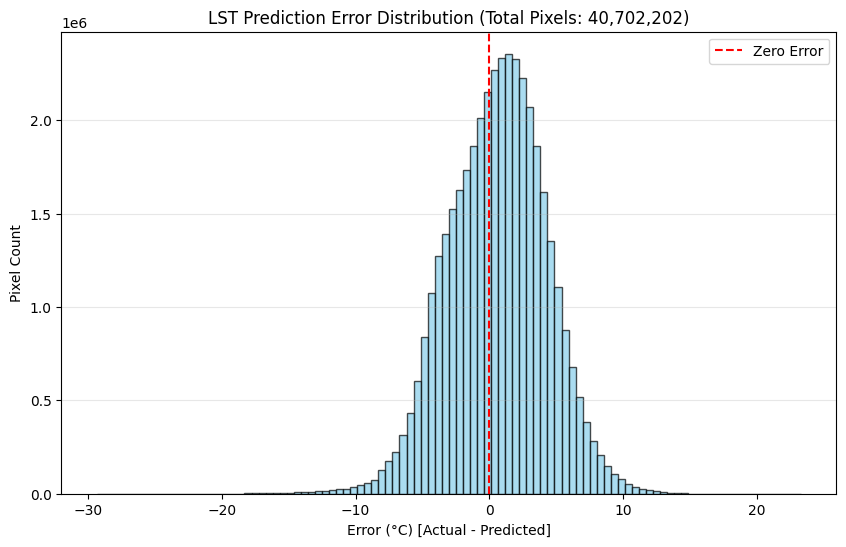

误差在 ±3°C 以内的像素比例为: 57.3%


In [6]:
import matplotlib.pyplot as plt

errors = (y_true - y_pred)

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
plt.title(f"LST Prediction Error Distribution (Total Pixels: {len(errors):,})")
plt.xlabel("Error (°C) [Actual - Predicted]")
plt.ylabel("Pixel Count")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()